In [18]:
## generate.ipynb
## Code to generate a Gaussian Random Field for velocities as a standard model for cloud
## scale star formation simulations. The field is guaranteed to be solenoidal.

import numpy as np
import h5py
import matplotlib.pyplot as plt
from generate import init_velocity_field_proj, init_velocity_field_kcurl, init_velocity_field_curl

In [27]:
# Example usage
N = 128
sigma = 1.0
kspec = 2
kmin = 0
kmax = 32
# Lorentz's Birthday: 18th of July, 1853
seed = 18071853


(vx,vy,vz) = init_velocity_field_proj(sigma, kspec, kmin, kmax, N, seed=seed)

The following few cells represent some analysis to check that the generated velocity field has the properties we want it to have. First, that it's 3D velocity dispersion is what we specified it to be. As you can see, there are three methods above that are used for generating the velocity field. You can try out each method by changing the name of the function in the last line of the above cell appropriately.

In [28]:
sigma_res = np.sqrt(np.std(vx)** 2 + np.std(vy)** 2 + np.std(vz)** 2)
print(sigma_res/sigma)

1.0


We also intended for the divergence of the velocity field to be zero (a solenoidal field). There are multiple ways to estimate the divergence of the velocity field so let's take a look at two different discretizations and compare them. First using centered differences, then using fourier transforms

In [29]:
# define some fourier space variables
k = np.fft.fftfreq(N, d=1.0 / N) * 2 * np.pi
KS = np.meshgrid(k, k, k, indexing="ij")
(KX, KY, KZ) = KS
KS = np.array(KS)
K = np.sqrt(KX**2 + KY**2 + KZ**2)

In [30]:
# centered differences
divv_cd  = (np.roll(vx, -1, axis = 0) -  np.roll(vx, 1, axis = 0))/(2*N)
divv_cd += (np.roll(vy, -1, axis = 1) -  np.roll(vy, 1, axis = 1))/(2*N)
divv_cd += (np.roll(vz, -1, axis = 2) -  np.roll(vz, 1, axis = 2))/(2*N)

# fourier transform
vx_k = np.fft.fftn(vx)
vy_k = np.fft.fftn(vy)
vz_k = np.fft.fftn(vz)

divv_k = 1j * (KX * vx_k + KY * vy_k + KZ * vz_k)
divv_ft = np.fft.ifftn(divv_k).real

print(np.std(divv_cd), np.std(divv_ft))

7.966450609623403e-05 0.0152458929675146


The use of $k_{\rm min} = 0$ leads to a non-negligible divergence from the Fourier Space estimate. The divergence from the Centered differences is still small so this shouldn't be much of a problem.

Next we would like to check that the velocity field we generated has the power spectrum that we desired. We can use the fourier transforms we calculated above to get the magnitude of the velocity field in fourier space

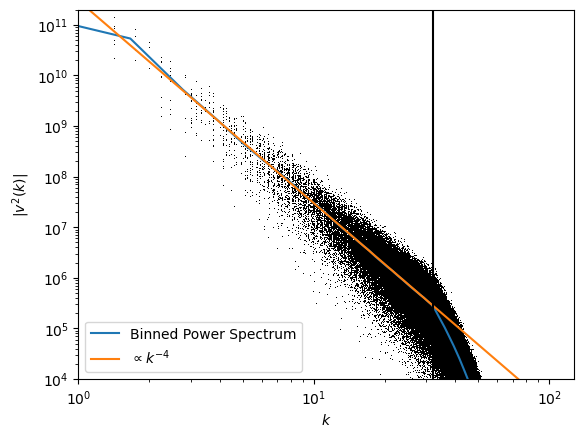

In [33]:
# magnitude in fourier space
magv_k = np.abs(vx_k)**2 + np.abs(vy_k)**2 + np.abs(vz_k)**2

# flatten things for plotting
Kflat = K.flatten()/(2*np.pi)
magv_k_flat = magv_k.flatten()

# bin the k-space power spectrum
(hist_mag, bes) = np.histogram(Kflat, weights=magv_k_flat, bins=100)
(hist_n, bes) = np.histogram(Kflat, bins=100)
bcs = 0.5 * (bes[1:] + bes[:-1])

plt.plot(Kflat,magv_k_flat,'k,')
plt.plot(bcs, hist_mag/hist_n, label="Binned Power Spectrum")
plt.plot(bcs, 3e11*bcs**(-2*kspec), label=r"$\propto k^{%d}$"%(-2*kspec))

plt.legend()
plt.xlabel(r"$k$")
plt.ylabel(r"$|v^2(k)|$")
plt.axvline(x=kmin,c="k")
plt.axvline(x=kmax,c="k")
plt.ylim(1e4,2e11)
plt.xlim(1,128)
plt.xscale("log")
plt.yscale("log")

Finally let's look at a slice of the velocity field. The velocity field is meant to just encompass the whole cloud being considered. We show a slice of the velocity field below with the edge of the cloud inscribed. When setting up the $\texttt{unicloud}^{\rm TM}$ initial conditions, one should set to zero all velocities which lie outside the cloud (outside the white circle below, but in 3D).

Text(0.5, 1.0, '$v_z$')

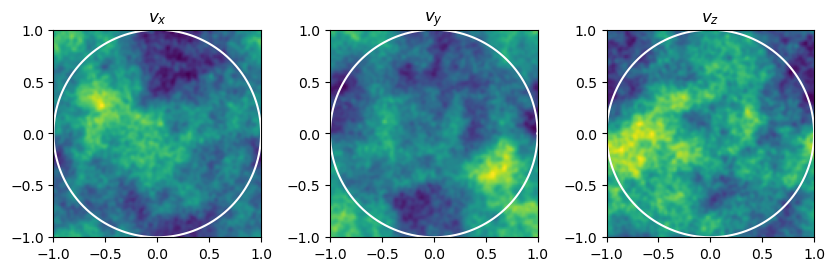

In [34]:
fig, axes = plt.subplots(1, 3, figsize=(3*3.37, 3.37*.8))
(ax1, ax2, ax3) = axes

im1 = ax1.imshow(vx[N//2,:,:],extent=(-1,1,-1,1))
im2 = ax2.imshow(vy[:,N//2,:],extent=(-1,1,-1,1))
im3 = ax3.imshow(vz[:,:,N//2],extent=(-1,1,-1,1))

t = np.linspace(0,2*np.pi, 1000)
x = np.cos(t)
y = np.sin(t)
for ax in [ax1,ax2,ax3]:
    ax.plot(x,y,'w')

ax1.set_title(r"$v_x$")
ax2.set_title(r"$v_y$")
ax3.set_title(r"$v_z$")


When you run the code in $\texttt{generate.py}$ it will generate several HDF5 file. You can read in the HDF5 file in python with the code below:

In [35]:
velocity_file = "velocity_field_seed0.h5"
with h5py.File(velocity_file, 'r') as h5file:
    # Read the velocity components
    vxf = h5file['vx'][:]
    vyf = h5file['vy'][:]
    vzf = h5file['vz'][:]

We can make a plot of this velocity field similarly

Text(0.5, 1.0, '$v_z$')

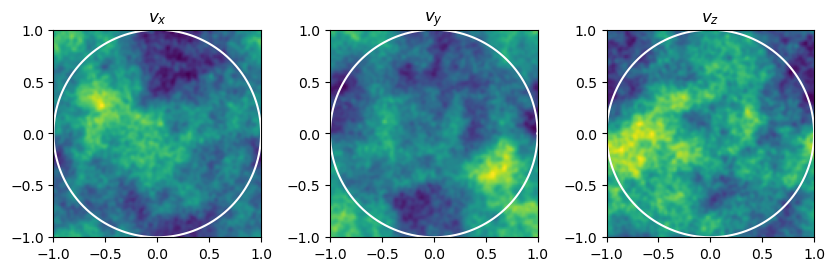

In [36]:
fig, axes = plt.subplots(1, 3, figsize=(3*3.37, 3.37*.8))
(ax1, ax2, ax3) = axes

im1 = ax1.imshow(vxf[N//2,:,:],extent=(-1,1,-1,1))
im2 = ax2.imshow(vyf[:,N//2,:],extent=(-1,1,-1,1))
im3 = ax3.imshow(vzf[:,:,N//2],extent=(-1,1,-1,1))

t = np.linspace(0,2*np.pi, 1000)
x = np.cos(t)
y = np.sin(t)
for ax in [ax1,ax2,ax3]:
    ax.plot(x,y,'w')

ax1.set_title(r"$v_x$")
ax2.set_title(r"$v_y$")
ax3.set_title(r"$v_z$")